In [55]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/reddit/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Goals of this Notebook
The goal of this notebook is to create a dataset that can be used to test hypotheses about the importance of reddit top page placement time on the number of newcomer comments and newcomer comment removals

### Load PRAW session

In [ ]:
r = conn.connect(controller="ModLog")

### Set Dates to Consider for this Analysis
To set this up, I ran the following query:

<em>select count(*), DATE(created_at) FROM subreddit_pages WHERE page_type=1 GROUP BY DATE(created_at);</em>

<pre>
+----------+------------------+
| count(*) | DATE(created_at) |
+----------+------------------+
|       15 | 2016-06-17       |
|      383 | 2016-06-28       |
|      719 | 2016-06-29       |
|      718 | 2016-06-30       |
|      663 | 2016-07-01       |
<font style="background:#ccc">|      178 | 2016-07-04       |</font> &lt;- Omit this date
|      720 | 2016-07-05       |
|      548 | 2016-07-06       |
|      358 | 2016-07-07       |
|      358 | 2016-07-08       |
|      359 | 2016-07-09       |
|      360 | 2016-07-10       |
|      360 | 2016-07-11       |
|      358 | 2016-07-12       |
|      360 | 2016-07-13       |
|      359 | 2016-07-14       |
|      268 | 2016-07-15       |
+----------+------------------+
17 rows in set (0.06 sec)
</pre>


In [30]:
dates = ['2016-07-05','2016-07-06','2016-07-07',
         '2016-07-08','2016-07-09','2016-07-10',
         '2016-07-11','2016-07-12','2016-07-13',
         '2016-07-14']
included_dates = [parser.parse(x).date() for x in dates]

### Create a Dataset of Posts Appearing on the Front Pages

In [43]:
subreddit_pages = []
for row in db_engine.execute(text('select * from subreddit_pages WHERE page_type=1 AND created_at>="2016-07-05" AND created_at <="2017-07-14" ORDER BY created_at;')):
    subreddit_page = {}
    subreddit_page['page']= json.loads(row['page_data'])
    for key in row.keys():
        subreddit_page[key] = row[key]
    if(subreddit_page['page'][0]['subreddit_id']=="t5_mouw" and subreddit_page['created_at'].date() in included_dates):
        subreddit_pages.append(subreddit_page)

In [88]:
def get_top_posts(page, n=10):
    return([x['name'] for x in page[0:n]])

def get_top_post_dates(page, n=10):
    dates = sorted([utc.localize(datetime.datetime.utcfromtimestamp(x['created_utc'])) for x in page[0:n]])
    return({"first":dates[0], "last":dates[-1]})

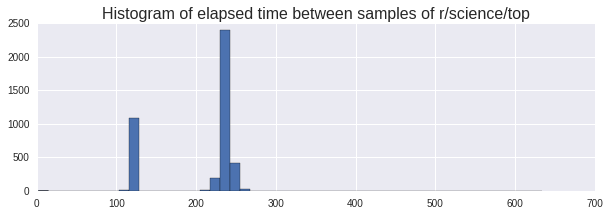

In [89]:
timediffs = []
last_time = None
for page in subreddit_pages:
    current_time = page['created_at']
    if(last_time is not None):
        timediffs.append((current_time - last_time).total_seconds())
    last_time = current_time

plt.figure(figsize=(10, 3)) 
plt.hist(timediffs, bins=50)
plt.title("Histogram of elapsed time between samples of r/science/top", fontsize=16)
plt.show()

In [92]:
post_minutes_on_top = defaultdict(int)
last_time = None
top_n = 10
top_post_dates={"first":None, "last":None}
for page in subreddit_pages:
    current_time = page['created_at']
    if(last_time is not None):
        estimated_time = (current_time - last_time).total_seconds() / 60.
    else:
        estimated_time = np.mean(timediffs)  / 60.
    
    for post in get_top_posts(page['page'], n=top_n):
        post_minutes_on_top[post] += estimated_time
    
    dates = get_top_post_dates(page['page'], n=top_n)
    if(top_post_dates['first'] is None or top_post_dates['first'] > dates['first']):
        top_post_dates['first'] = dates['first']
    if(top_post_dates['last'] is None or top_post_dates['last'] < dates['last']):
        top_post_dates['last'] = dates['last']
    
    last_time = current_time

print("Date Range: {0} to {1}".format(str(top_post_dates["first"]), str(top_post_dates["last"])))
print("{0} Total pages analyzed".format(len(subreddit_pages)))
print("{0} Total posts appeared on the Top {1} listing for r/science".format(len(post_minutes_on_top), top_n))

Date Range: 2016-07-04 04:43:10+00:00 to 2016-07-14 21:42:52+00:00
4140 Total pages analyzed
239 Total posts appeared on the Top 10 listing for r/science


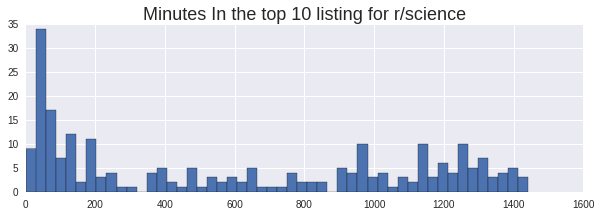

In [93]:
plt.figure(figsize=(10, 3)) 
plt.hist([x for x in post_minutes_on_top.values()], bins=50)
plt.title("Minutes In the top {0} listing for r/science".format(top_n), fontsize=18)
plt.show()

### Load Baumgartner Posts from the specified dates (includes some gaps)

In [101]:
post_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)
science_posts = {}
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/baumgartner_science_posts_2016_07_15_1500.json", "r") as lines:
    for line in lines:
        post = json.loads(line)
        post['created'] = parser.parse(post['created_utc'])
        if(post['created'] >= top_post_dates['first'] and post['created'] <= top_post_dates['last']):
            post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days
            full_id = "t3_" + post['id']
            if(full_id in post_minutes_on_top):
                post['post.sub.top.minutes'] = post_minutes_on_top[full_id]
            else:
                post['post.sub.top.minutes'] = 0
            science_posts[post['id']] = post
            post_ids.add(post['id'])

### Create a Pandas Dataframe from data

In [106]:
posts_df = pd.DataFrame(list(science_posts.values()))

### Plot posts per day in the the sample period

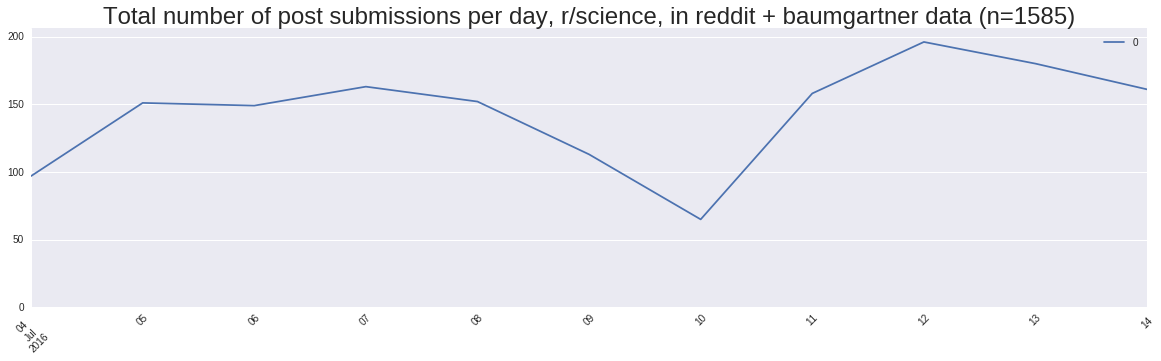

In [117]:
x = pd.DataFrame(posts_df.created.values, index=posts_df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(posts_df.created.count()), fontsize="24")

### Load Moderator Actions Going Back to The Beginning of the Sample Period

In [124]:
recent_mod_actions = []
earliest_date = str(top_post_dates['first'].date())
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="mouw" AND created_utc >= "{0}" ORDER BY created_utc;'.format(earliest_date))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

19248 moderator actions loaded


### Tag posts as visible or non-visible based on moderation log

In [168]:
posts_2016 = {}
for post in posts_df[posts_df.created>=recent_mod_actions[0]['created']].to_dict("records"):
    post['visible'] = True
    posts_2016[post['id']] = post
recent_post_count = len(posts_2016.values())
print("Recent Post Count: {0}".format(recent_post_count))

Recent Post Count: 1585


### Find missing posts mentioned in the moderation log

In [169]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Missing Mod Actions: 134
Missing Mod Action Posts: 97
Matched Mod Actions: 1753


### Fetch missing posts from reddit

In [170]:
extra_posts = []
for submission in r.get_submissions(["t3_" + x for x in set(missing_mod_actions)]):
    extra_posts.append(submission.json_dict)

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/by_id/t3_4syh1b,t3_4r5fry,t3_4swoyb,t3_4sz5v7,t3_4swezk,t3_4szf3t,t3_4syqgs,t3_4t01gi,t3_4syu54,t3_4t09pk,t3_4sxwh8,t3_4svv20,t3_4sxt3d,t3_4szbtt,t3_4syhgu,t3_4syqpl,t3_4swzhv,t3_4r4r5t,t3_4swq59,t3_4sw49w,t3_4sx0x8,t3_4syxvh,t3_4syl7p,t3_4sw3e5,t3_4r25as,t3_4swt3y,t3_4sz86b,t3_4syqyj,t3_4syicz,t3_4r54sl,t3_4sx9ub,t3_4szb40,t3_4svvpb,t3_4sw59v,t3_4sxhoh,t3_4sxk85,t3_4sw3qx,t3_4sy78t,t3_4r5csu,t3_4t030u,t3_4szl57,t3_4t00ub,t3_4sz0yb,t3_4sxf7n,t3_4szfna,t3_4r3n11,t3_476d3i,t3_4t0crz,t3_4sy9br,t3_4szi5f,t3_4szz0r,t3_4sz28h,t3_4t0jqh,t3_4t00eg,t3_4t0mv3,t3_4sxg2r,t3_4sysqs,t3_4svwcn,t3_4szohr,t3_4sxlvy,t3_4sw25s,t3_4sz7j9,t3_4syiqg,t3_4sx6tf,t3_4r3jll,t3_4sxi0g,t3_4sxrwe,t3_4ftuwu,t3_4swe7h,t3_4szy3k,t3_4t0c4n,t3_4syx4p,t3_4sy1s5,t3_4szwch,t3_4t01xw,t3_4sy3w1,t3_4sw6xg,t3_4sxhy3,t3_3eret9,t3_4swj6f,t3_4syrpw,t3_4syd2i,t3_4qel5f,t3_4sxmcy,t3_4t043g,t3_4t038f,t3_4szucc,t3_4svtoa,t3_4szzyo,t3

In [171]:
### AND NO NEED TO GO BACK THROUGH THE MODERATION ACTION LIST
### FOR THESE, SINCE THEY WILL HAVE THE banned_by PROPERTY

outside_time_window = 0
within_time_window = 0
tail = top_post_dates['last']

for post in extra_posts:
    post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
    if post['created'] >= recent_mod_actions[0]['created'] and post['created'] <= tail:
        if(post['banned_by'] is not None):
            post['visible'] = False
        else:
            post['visible'] = True
        post['post.sub.top.minutes'] = 0
        posts_2016[post['id']] = post
        within_time_window += 1
    else:
        outside_time_window += 1
    
print("Extra posts within time window: {0}".format(within_time_window))
print("Extra posts outside time window: {0}".format(outside_time_window))
    
for post in posts_2016.values():
    post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days

Extra posts within time window: 0
Extra posts outside time window: 97


### Create Dataframe to Chart Submitted versus Permitted Posts Per Day

In [172]:
recent_posts = pd.DataFrame(list(posts_2016.values()))
print("Posts before update from modlog: {0}".format(recent_post_count))
print("Posts after update from modlog: {0}".format(recent_posts.created.count()))

Posts before update from modlog: 1585
Posts after update from modlog: 1585


### Plot Posts Per Day in Recent History of Subreddit

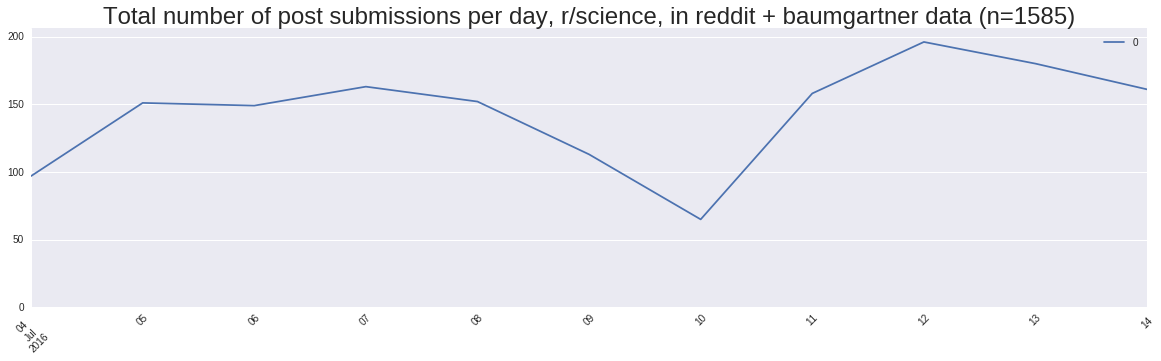

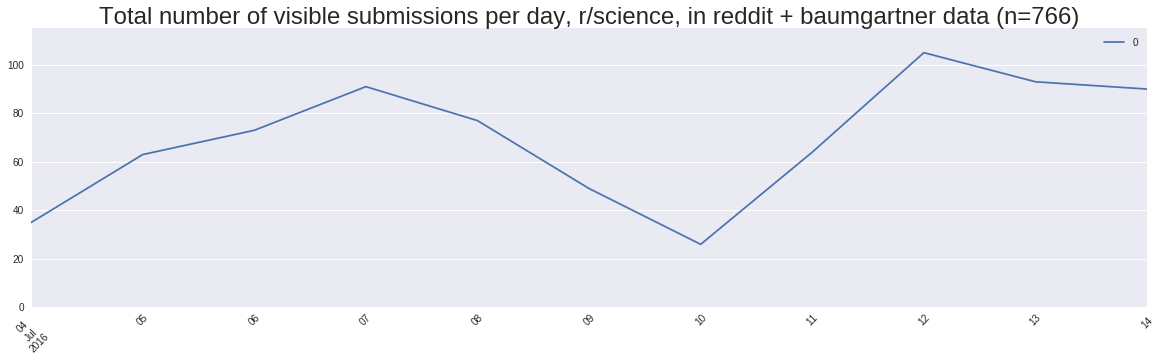

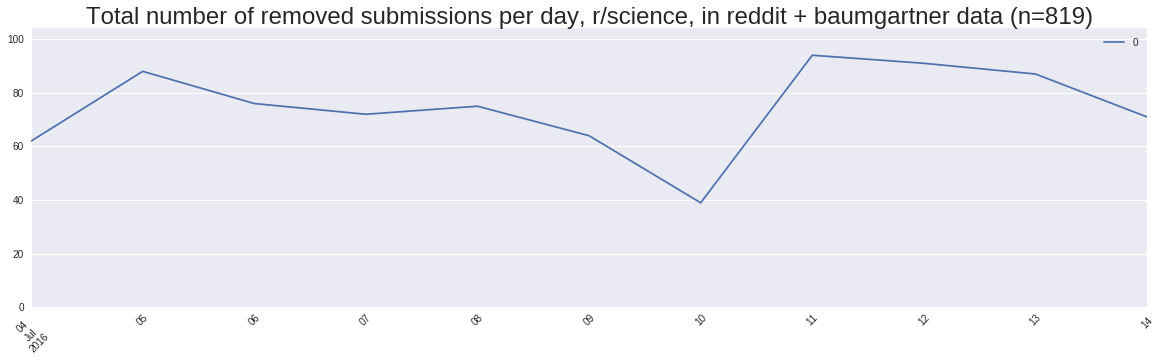

In [173]:
### TOTAL SUBMISSIONS
df = recent_posts[((recent_posts.created <= top_post_dates['last']) &
                   (recent_posts.created >= top_post_dates['first']))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of post submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

total_counts = x.resample("D").count().to_dict("records")

### NOW ACCEPTED SUBMISSIONS
df = recent_posts[((recent_posts.visible == True) & 
                   (recent_posts.created <= top_post_dates['last']) &
                   (recent_posts.created >= top_post_dates['first']))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of visible submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

retained_counts = x.resample("D").count().to_dict("records")

### NOW REMOVED SUBMISSIONS
df = recent_posts[((recent_posts.visible == False) & 
                   (recent_posts.created <= top_post_dates['last']) &
                   (recent_posts.created >= top_post_dates['first']))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of removed submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

# Construct Dependent Variables: 
* newcomer comments on posts that are allowed to remain
* the number of newcomer comments on posts that are allowed to remain
* the number of removed newcomer comments on posts that are allowed to remain

### Load last six months of comments from official reddit dataset

In [174]:
comment_head = parser.parse("2015-12-01 00:00:00 UTC")
all_comments = {}
comment_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)

for filename in [#'/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_12_2015.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_01_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_02_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_03_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_04_2016.json',
                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_05_2016.json']:
    sys.stdout.write(".")
    sys.stdout.flush()
    with open(filename, "r") as lines:
        for line in lines:
            comment = json.loads(line)
            if(comment['id'] not in comment_ids):
                comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
                comment['visible'] = True
                if(comment['body'] == "[removed]"):
                    comment['visible'] = False
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])

.....

### Load Baumgartner Comments from the last month
Unlike the post data, I checked this and found no gaps, at least going from the moderation log


In [175]:
## Omitting tails for this analysis
#tail = parser.parse('2016-05-30 23:59:59 UTC')
count = 0
with open("/mnt/corsair/reddit_archive/baumgartner-bigquery-data/reddit_science_comments_2016.json", "r") as comment_file:
    for line in comment_file:
        comment = json.loads(line)
        if(comment['id'] not in comment_ids):
            comment['created'] = parser.parse(comment['created_utc'])
#            if(comment['created'] <= tail):
            comment['body.length'] = len(comment['body'])
            comment['body'] = None
            comment['body_html'] = None
            comment['visible'] = True
            if(comment['body'] == "[removed]"):
                comment['visible'] = False
            all_comments[comment['id']] = comment
            comment_ids.add(comment['id'])
        count += 1
        if(count % 50000 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()

........

### Identify Missing Coments from Moderation Log

In [176]:
missing_comment_ids = []
for action in recent_mod_actions:
    if action['target_fullname'] is not None and "t1_" in action['target_fullname']:
        if action['target_fullname'].replace("t1_", "") not in all_comments.keys():
            missing_comment_ids.append(action['target_fullname'])
print("Missing Comments: {0}".format(len(missing_comment_ids)))

### FETCH COMMENT INFORMATION FOR ALL MISSING COMMENTS
missing_comments = []
counter = 0
for comment_obj in r.get_info(thing_id=missing_comment_ids):
    comment = comment_obj.json_dict
    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
    comment['visible'] = True
    if(comment['body'] == "[removed]" or comment['banned_by'] is not None):
        comment['visible'] = False
    comment['body.length'] = len(comment['body'])
    comment['body'] = None
    comment['body_html'] = None
    missing_comments.append(comment)
    counter += 1

Missing Comments: 16935


substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com

In [177]:
print("Found {0} additional comments moderated during the newcomer period and moderation log period".format(len(missing_comments)))
print("{0} of these comments have the author [deleted]".format(len([x for x in missing_comments if x['author']=="[deleted]"])))
print("{0} of these comments were removed.".format(len([x for x in missing_comments if x['visible']==False])))
mod_action_head = recent_mod_actions[0]['created']
comments_in_comment_period = len([x for x in missing_comments if (mod_action_head < x['created'] and tail >= x['created'])])
print("{0} of these fall within the period covered by the moderation log.".format(comments_in_comment_period))

newcomer_head = parser.parse("2016-01-01 00:00:00 UTC")
comments_in_newcomer_period = len([x for x in missing_comments if (newcomer_head < x['created'] and tail >= x['created'])])
print("{0} of these fall within the period used for calculating newcomers.".format(comments_in_newcomer_period))

added_count = 0
for comment in missing_comments:
    if(comment['created'] >= newcomer_head and comment['created'] <= tail):
        all_comments[comment['id']] = comment
        added_count +=1
print("")
print("{0} comments added to all_comments".format(added_count))

Found 16935 additional comments moderated during the newcomer period and moderation log period
934 of these comments have the author [deleted]
15877 of these comments were removed.
16219 of these fall within the period covered by the moderation log.
16267 of these fall within the period used for calculating newcomers.

16267 comments added to all_comments


### Construct a time sorted list of comments on the sampled posts

In [178]:
import heapq

EPOCH = utc.localize(datetime.datetime.utcfromtimestamp(0))

class CommentHeapObj(object):
    def __init__(self, comment):
        self.index = int((comment['created'] - EPOCH).total_seconds())
        self.val = comment
    def __lt__(self, other):
        return self.index < other.index

def heapsort(comments):
    h = []
    for comment in comments:
        heapq.heappush(h, CommentHeapObj(comment))
    return [heapq.heappop(h).val for i in range(len(h))]

all_comments = heapsort(all_comments.values())

### Add Moderation Actions to Comments, Setting Comments as Visible or Not Visible

In [180]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
approved_count = 0
removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()

for action in recent_mod_actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

16529 Total moderation actions
14649 Comments with moderation actions
1775 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 353239, False: 172692})
Took 15437 actions to set a comment to removed
Took 466 actions to set a comment to approved


### Add Author Comment Number to All Comments

In [181]:
author_comment_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.comments'] = author_comment_num[comment['author']]    
    author_comment_num[comment['author']] += 1


### Add Author Removed Count to All Comments

In [182]:
from collections import defaultdict, Counter

author_removed_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.removed'] = author_removed_num[comment['author']]  
    if(comment['visible']==False):
        author_removed_num[comment['author']] += 1

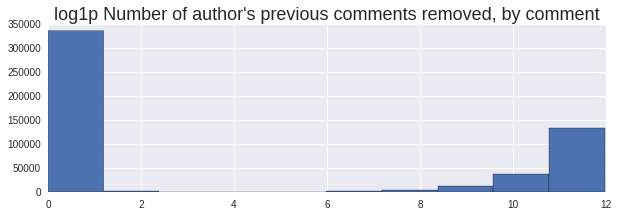

In [183]:
import math
plt.figure(figsize=(10, 3)) 
plt.hist([math.log1p(x['author.prev.removed']) for x in all_comments])
plt.title("log1p Number of author's previous comments removed, by comment", fontsize="18")
plt.show()

# Create Dataframes for Analysis

### Create a Dataset of Comments from The Front Page Observation Period forward
Tagged comments with information about the post they were attached to, including:
* were they top-level comments or replies?
* what flair did the post have
* what time was the post made
* was the post removed

In [184]:
## TODO: set head and tail for comments dataset.
## Head for comments should be the creation time of the first post in the dataset
## Tail should be the last comment time of the last comment in a post in the dataset
# Initial value: the date of creation of the last science post
tail = sorted([x['created'] for x in science_posts.values()])[-1]
comment_head = sorted([x['created'] for x in science_posts.values()])[0]
for comment in all_comments:
    if((comment['link_id'].replace("t3_", "") in science_posts.keys()) and comment['created'] > tail):
        tail = comment['created']
print("{0} is the tail".format(tail))
print("{0} is the head".format(comment_head))

2016-07-14 21:42:52+00:00 is the tail
2016-07-04 04:43:10+00:00 is the head


In [185]:
recent_comments = [x for x in all_comments if x['created']>=comment_head and x['created']<= tail]
print("Total number of comments: {0}".format(len(all_comments)))
print("Recent comments: {0}".format(len(recent_comments)))

Total number of comments: 525931
Recent comments: 14275


#### (In this version, we do not fetch any missing posts, since we are only concerned with posts made within the analysis period. Any missing posts will be posts outside analysis period that received comments within the analysis period)

In [186]:
# recent_comment_posts = list(set([x['link_id'] for x in recent_comments]))
# unfetched_posts = []
# for post in recent_comment_posts:
#     if post.replace("t3_", "") not in posts_2016.keys():
#         unfetched_posts.append(post)

# new_posts_fetched = 0
# new_posts_saved = 0
# for submission in r.get_submissions(unfetched_posts):
#     new_posts_fetched += 1
#     post = submission.json_dict
#     post['created'] = utc.localize(datetime.datetime.utcfromtimestamp(int(post['created_utc'])))
# #    we add all posts, so that we can fetch the covariates. But we omit them from the posts df
# #    if(post['created'] > comment_head and post['created'] <= tail):
        

#     post['day.num'] = (post['created'] - utc.localize(datetime.datetime(1970,1,1))).days
#     ## we do actually want to get all posts in this set so we can add their covariates
#     if(post['banned_by'] is not None):
#         post['visible'] = False
#     else:
#         post['visible'] = True
#     if(post['created'] < tail and post['created'] > comment_head)
#         posts_2016[post['id']] = post
#         new_posts_saved ++ 1
# print("Fetched {0} new posts".format(new_posts_fetched))
# print("Saved {0} new posts".format(new_posts_saved))

#### Fetch full post information for all posts

In [195]:
all_post_ids = ["t3_" + post_id for post_id in posts_2016.keys()]
additions = 0
for post_object in r.get_info(thing_id=all_post_ids):
    post = post_object.json_dict
    for key in post.keys():
        if key not in posts_2016[post['id']].keys():
            posts_2016[post['id']][key] = post[key]
            additions += 1
print("{0} fields updated".format(additions))

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com

57612 fields updated


#### Now attach post-level covariates to comments

In [203]:
def is_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "ama" in flair

def is_badpost(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "badpost" in flair

def strip_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
#    try:
    flairs = [x for x in flair.split() if("ama" not in x and "badpost" not in x)]
#    except:
#        import pdb;pdb.set_trace()
    if(len(flairs)==0):
        return None
    return flairs[0] ## Confirmed that this is always only one flair

recent_comments_included = []
for comment in recent_comments:
    post_id = comment['link_id'].replace("t3_", "")
    if(post_id in posts_2016.keys()):
        post = posts_2016[comment['link_id'].replace("t3_", "")]
        comment['post.ama'] = is_ama(post['link_flair_css_class'])
        comment['post.badpost'] = is_badpost(post['link_flair_css_class'])
        comment['post.flair'] = strip_ama(post['link_flair_css_class'])
        comment['post.created'] = post['created']
        comment['minutes.since.post.created'] = (comment['created'] - post['created']).total_seconds() / 60.
        comment['post.sub.top.minutes'] = post['post.sub.top.minutes']
        comment['post.author'] = post['author']
        comment['post.visible'] = post['visible']
        comment['toplevel'] = comment['link_id'] == comment['parent_id']
        comment['post.domain'] = post['domain']
        comment['post.day.num']  = post['day.num']
        comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
        comment['weekday'] = comment['created'].weekday()
        comment['weekend'] = (comment['weekday'] >=6)
        recent_comments_included.append(comment)


In [204]:
import time
recent_comment_df = pd.DataFrame(recent_comments_included)
earliest_datetime = recent_comments[0]['created'].strftime("%Y.%m.%d_%H.%M.%S")
latest_datetime = recent_comments[-1]['created'].strftime("%Y.%m.%d_%H.%M.%S")
recent_comments_filename = "r_science_comments_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_comment_df.to_csv(os.path.join("outputs",recent_comments_filename))

In [205]:
print("{0} comments by newcomers".format(recent_comment_df[recent_comment_df['author.prev.comments']==0].created.count()))
#print("{0} newcomer comments that were removed")
print("{0} comments by newcomers that were removed".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False))].created.count()))
print("{0} comments by newcomers that were removed, whose accounts were not later deleted".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False) & (recent_comment_df.later_deleted==False))].created.count()))

5889 comments by newcomers
5753 comments by newcomers that were removed
5411 comments by newcomers that were removed, whose accounts were not later deleted


#### Now Generate and output a post-level dataset

In [206]:
#recent_comments[0]['created']
next_period_start = (recent_comments_included[0]['created'] + datetime.timedelta(days=1)).replace(hour = 10, minute=0, second=0)
print(next_period_start)
datetime.timedelta(days=1).total_seconds()
#day_later - datetime.timedelta(hours = day_later.hour, minutes = day_later)

2016-07-05 10:00:00+00:00


86400.0

In [207]:
# from comment_head onward
#post_comments = {}
for post in posts_2016.values():
#    post['newcomer.commenters'] = set()
    post['newcomer.comments'] = 0
    post['newcomer.comments.experiment.day'] = 0
    post['newcomer.comments.experiment.after'] = 0

    post['newcomer.comments.removed'] = 0
    post['newcomer.comments.removed.experiment.day'] = 0
    post['newcomer.comments.removed.experiment.after'] = 0

    post['commenters'] = set()
    
    post['experiment.day'] = post['created'].replace(hour = 10, minute=0, second=0)
    post['experiment.day.next'] = (post['experiment.day'] + datetime.timedelta(days=1))
    post['experiment.day.minutes'] = int((post['experiment.day.next'] - post['created']).total_seconds() / 60.)
                                   
    post['num.comments.experiment.day'] = 0
    post['num.comments.experiment.after'] = 0
                                   
    post['num.comments']  = 0
    post['num.comments.removed'] = 0
    post['num.comments.removed.experiment.day'] = 0
    post['num.comments.removed.experiment.after'] = 0
                                   
    post['post.ama'] = is_ama(post['link_flair_css_class'])
    post['post.badpost'] = is_badpost(post['link_flair_css_class'])
    post['post.flair'] = strip_ama(post['link_flair_css_class'])
    post['weekday'] = post['created'].weekday()
    post['weekend'] = (post['weekday'] >=6)
    
for comment in recent_comments_included:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    post['commenters'].add(comment['author'])
    
    
    post['num.comments'] += 1
    if(comment['created'] <= post['experiment.day.next']):
        post['num.comments.experiment.day'] += 1 
    else:
        post['num.comments.experiment.after'] += 1
    
    if(comment['visible']!=True):
        post['num.comments.removed'] +=1
        if(comment['created'] <= post['experiment.day.next']):
            post['num.comments.removed.experiment.day'] += 1
        else:
            post['num.comments.removed.experiment.after'] += 1            
        
    ## IF THE COMMENT AUTHOR IS A NEWCOMER
    if comment['author.prev.comments'] == 0:
        post['newcomer.comments'] += 1
        
        if(comment['created'] <= post['experiment.day.next']):
            post['newcomer.comments.experiment.day'] += 1
        else:
            post['newcomer.comments.experiment.after'] += 1
        
        if(comment['visible']!=True):
            post['newcomer.comments.removed'] += 1
    
            if(comment['created'] <= post['experiment.day.next']):
                post['newcomer.comments.removed.experiment.day'] += 1
            else:
                post['newcomer.comments.removed.experiment.after'] += 1


for post in posts_2016.values():
    post['num.commenters'] = len(post['commenters'])
    del post['commenters']

In [208]:
print("{0} posts overall".format(len(list(posts_2016.values()))))
print("{0} posts within the analysis period".format(len([x for x in posts_2016.values() if (x['created'] > comment_head and x['created'] <= tail)])))

1585 posts overall
1584 posts within the analysis period


In [209]:
recent_post_df = pd.DataFrame([x for x in posts_2016.values() if (x['created'] > comment_head and x['created'] <= tail)])
recent_posts_filename = "r_science_posts_" + earliest_datetime + "-" + latest_datetime + ".csv"
recent_post_df.to_csv(os.path.join("outputs", recent_posts_filename))